# Spatial IsoDepth Calculation

GASTON is an interpretable deep learning model for learning the gene expression topography of a tissue slice from spatially resolved transcriptomics (SRT) data. GASTON models gene expression topography by learning the isodepth, a 1-D coordinate describing continuous gene expression gradients and tissue geometry (i.e. spatial domains).

Here, we introduce method integrated in omicverse named `GASTON`. 

We made three improvements in integrating the `GASTON` algorithm in OmicVerse:
- We reduced the installation conflict of `GASTON`, user only need to update OmicVerse to the latest version.
- We optimized the visualization of `GASTON` and simplify the function input of `GASTON`.
- We have fixed some bugs that could occur during function.

Besides, all functions you could find in `omicverse.externel.GASTON` if you want to use the raw functuion to run [GASTON's tutorial](https://gaston.readthedocs.io/en/latest/index.html)

In [2]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.11, Tutorials: https://omicverse.readthedocs.io/


## Prepared stRNA-seq

First let’s read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [3]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata

reading /scratch/users/steorra/analysis/omicverse/omicverse_guide/docs/Tutorials-space/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:01)


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

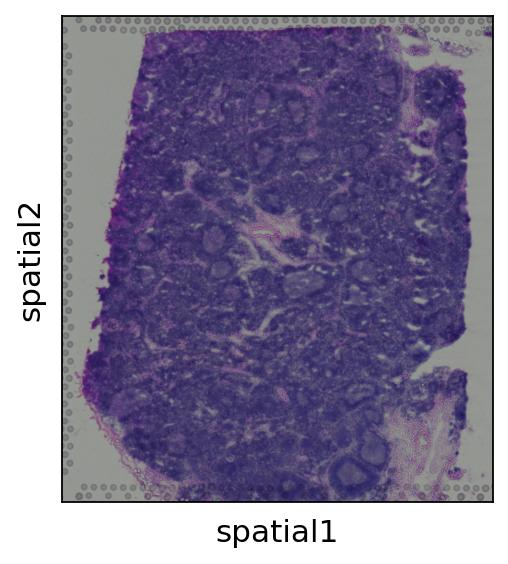

In [5]:
sc.pl.spatial(adata,
             color=None,
             show=False)

## Use top PCs of analytic Pearson residuals

Here we compute PCA on analytic Pearson residuals following the Scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html tutorial . This is faster than GLM-PCA, but the PCs are of lower quality, so it is not recommended

In [6]:
gas_obj=ov.space.GASTON(adata)
gas_obj.get_gaston_input(get_rgb=True,spot_umi_threshold=50)
A=gas_obj.get_top_pearson_residuals(num_dims=8,clip=0.01,n_top_genes=5000,
                                 use_RGB=True)


filtered out 1 cells that have less than 50 counts
Adding image layer `img1`
calculating RGB
Calculating features `['summary']` using `1` core(s)


  0%|          | 0/4034 [00:00<?, ?/s]

/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Adding `adata.obsm['features']`
Finish (0:00:30)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
computing PCA
    with n_comps=8
    finished (0:00:00)


We first load GLM-PCs and coordinates and z-score normalize.

In [7]:
gas_obj.load_rescale(A)

## Training the GASTON model

Next we train the neural network, once for each random initialization.

NEURAL NET PARAMETERS (USER CAN CHANGE)
architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
- isodepth_arch: architecture for isodepth neural network d(x,y) : R^2 -> R 
- expression_fn_arch: architecture for 1-D expression function h(w) : R -> R^G
- num_epochs: number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
- checkpoint: save model after number of epochs = multiple of checkpoint
- out_dir: folder to save model runs
- optimizer:
- num_restarts=20

In [7]:
out_dir='/scratch/users/steorra/tmp/tmp'
gas_obj.train(
    isodepth_arch=[20,20],
    expression_fn_arch=[20,20],
    num_epochs=5000,
    checkpoint=500,
    out_dir=out_dir,
    optimizer="adam",
    num_restarts=20
)

100%|██████████| 20/20 [11:01<00:00, 33.08s/it]


## Visualization

If you use the model trained above, then figures will closely match the manuscript — but not exactly match — due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ).

We also include the model used in the paper for reproducibility.


best model: /scratch/users/steorra/tmp/tmp/rep9
Kneedle number of domains: 4


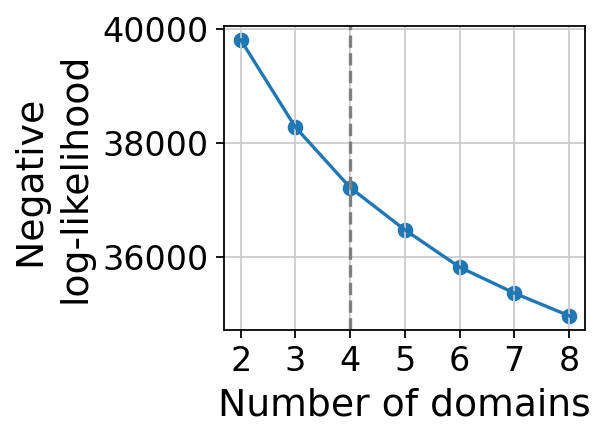

In [8]:
out_dir='/scratch/users/steorra/tmp/tmp'
gaston_model, A, S=gas_obj.get_best_model(out_dir=out_dir,
                       max_domain_num=8,start_from=2)

### Calculate the IsoDepth and Labels

We can chose the number of layers from IsoDepth

In [95]:
gaston_isodepth, gaston_labels=gas_obj.cal_iso_depth(5)

In [96]:
adata.obs['gaston_labels']=[str(i) for i in gaston_labels]
adata.obs['gaston_isodepth']=gaston_isodepth

[<AxesSubplot: title={'center': 'gaston_labels'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'gaston_isodepth'}, xlabel='spatial1', ylabel='spatial2'>]

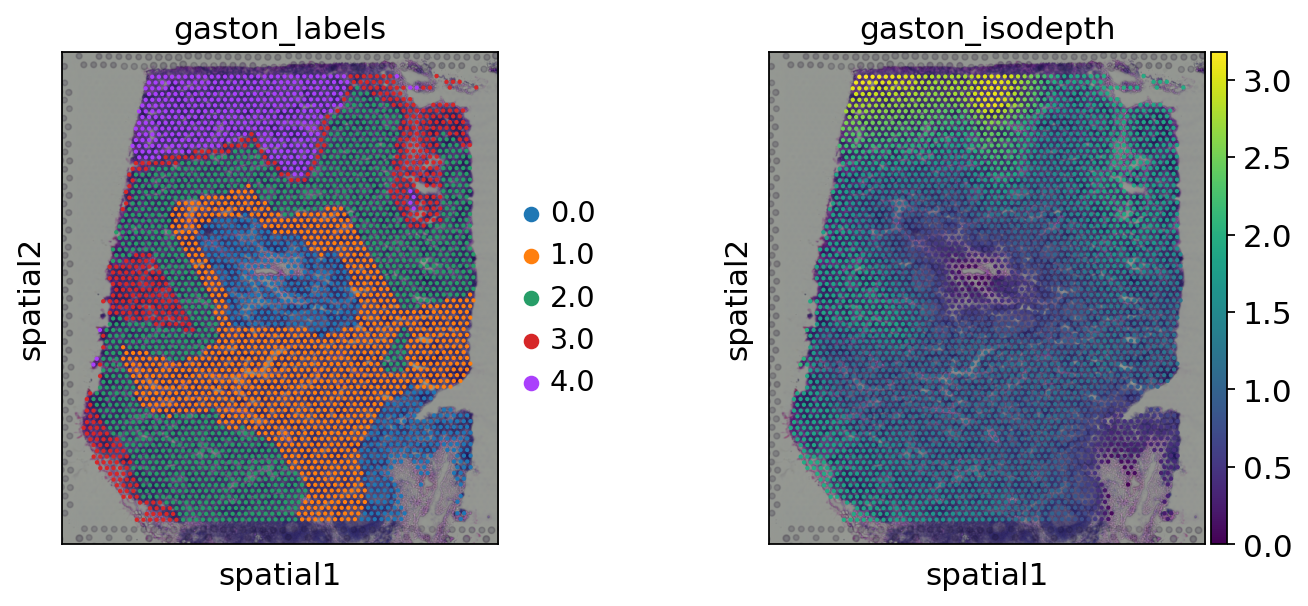

In [97]:
sc.pl.spatial(adata,
             color=['gaston_labels','gaston_isodepth'],
             show=False)

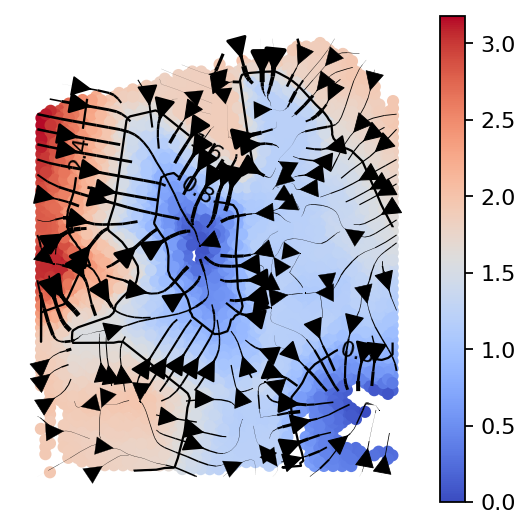

In [10]:
gas_obj.plot_isodepth(show_streamlines=True,
                      rotate_angle=-90,arrowsize=2,
                      figsize=(4,4),n_neighbors=100)

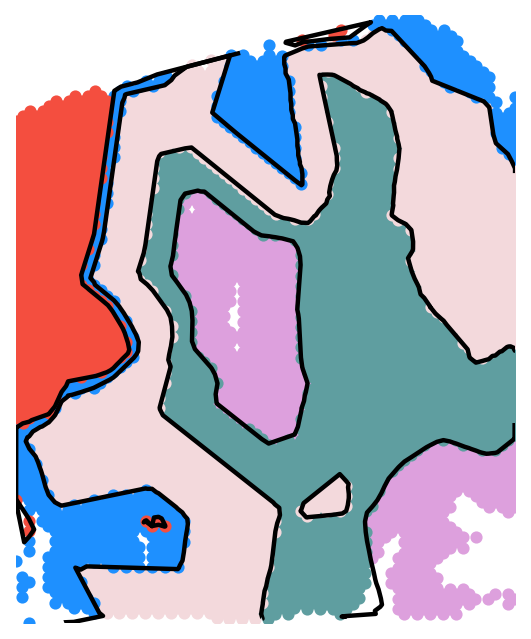

In [17]:
domain_colors=['plum', 'cadetblue', '#F3D9DC','dodgerblue', '#F44E3F']
gas_obj.plot_clusters(
    domain_colors,
    boundary_lw=2,
    figsize=(4,5),
    rotate_angle=-90,
)

### Specific to this analysis: restrict to domains (0,1)

To isolate the tumor section, we restrict to spots with isodepth lying in a given range. The range of isodepth values will need to be tuned depending on the specific application.

In some cases, the tissue geometry cannot be represented with a single isodepth. In this case, we recommend first subsetting your tissue to the specific region of interest (eg from ScanPy clustering), and then running GASTON


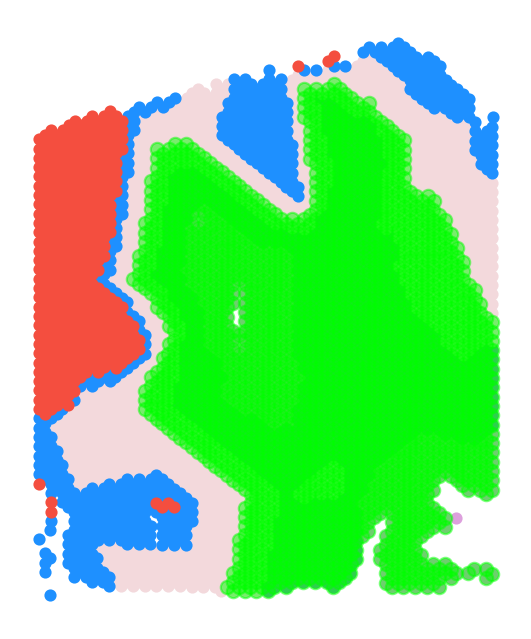

In [20]:
gas_obj.plot_clusters_restrict(
    domain_colors,
    isodepth_min=0,
    isodepth_max=1.5,
    rotate_angle=-90,
    s=20,lgd=False,
    figsize=(4,5)
)

restricting to 2280 spots


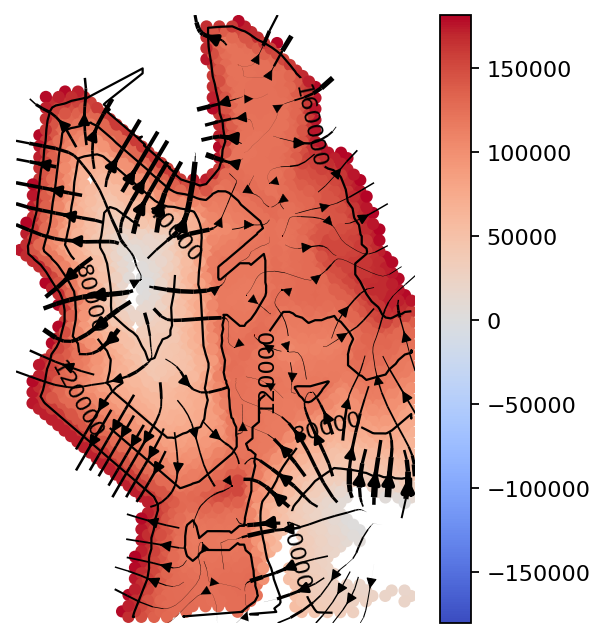

In [21]:
counts_mat_restrict, coords_mat_restrict, gaston_isodepth_restrict, gaston_labels_restrict, S_restrict=gas_obj.restrict_spot(
    isodepth_min=0,
    isodepth_max=1.5,
    adjust_physical=True,
    scale_factor=100,
    plotisodepth=True,
    show_streamlines=True,
    rotate_angle=-90,
    arrowsize=1, figsize=(4,5), 
    neg_gradient=True,
    n_neighbors=500
)

In [22]:
gas_obj.filter_genes(
    umi_thresh = 1000,
    exclude_prefix=['MT-', 'RPL', 'RPS']
)

In [ ]:
pw_fit_dict=gas_obj.pw_linear_fit()
binning_output=gas_obj.bin_data(
    num_bins=15,
    q_discont=0.95,
    q_cont=0.8
)


The `binning_output`, `cont_genes_layer` and `discont_genes_layer` stored in `gas_obj`

In [ ]:
ad=gas_obj.get_restricted_adata(gas_obj,offset=10**6)

### Plot discontinuous and continuous genes

We can found the discontinuous genes using `gas_obj.discont_genes_layer` and found continuous genes using `gas_obj.cont_genes_layer`

In [34]:
dict(gas_obj.cont_genes_layer)['MARCO']

[0, 2]

gene MARCO: discontinuous jump after domain(s) []
gene MARCO: continuous gradient in domain(s) [0, 2]


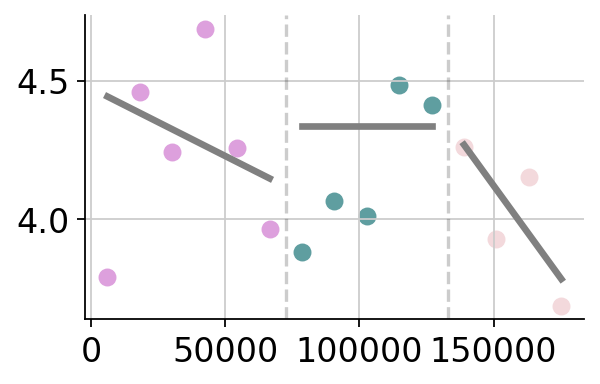

In [67]:
gene='MARCO'
gas_obj.plot_gene_pwlinear(gene,domain_colors,offset=10**6,
                           cell_type_list=None,pt_size=50,linear_fit=True,
                           ticksize=15, figsize=(4,2.5),
                           lw=3,domain_boundary_plotting=True)

### Plot cell type vs isodepth (if cell type info available)

Load cell type label per spot (from tangram). The tutorial and result could be found in https://omicverse.readthedocs.io/en/latest/Tutorials-space/t_mapping/

We store as N x C dataframe M where M[i,c]=1 if spot i is cell type c, and 0 if not

In [82]:
cell_type_df=ov.pd.read_csv('data/V1_Human_Lymph_Node_celltype.csv', index_col=0)
cell_type_df.head()

,Macrophages_M1,B_IFN,B_GC_LZ,Mast,B_activated,B_GC_DZ,B_mem,T_CD8+_naive,FDC,B_GC_prePB,...,Endo,T_CD8+_cytotoxic,T_CD4+,B_Cycling,T_CD4+_naive,ILC,T_CD4+_TfH,T_CD8+_CD161+,NKT,NK
AAACAAGTATCTCCCA-1,0.082171,0.000017,0.021260,0.000019,0.259048,0.030650,0.504739,0.411314,0.000519,0.000018,...,0.376284,0.043815,0.127287,0.233432,0.006444,0.064583,0.354094,0.170322,0.022457,0.199254
AAACAATCTACTAGCA-1,0.105147,0.000004,0.087364,0.000134,0.009732,0.005403,0.205373,0.039582,0.110013,0.000051,...,0.149988,0.154454,0.160099,0.229329,0.703887,0.057109,0.412450,0.003166,0.053408,0.010387
AAACACCAATAACTGC-1,0.112886,0.000004,0.023793,0.000220,0.228582,0.001881,0.536273,0.156701,0.001156,0.000022,...,0.326906,0.183677,0.110817,0.252126,0.018042,0.083709,0.134888,0.281477,0.001987,0.273480
AAACAGAGCGACTCCT-1,0.150097,0.920552,0.083713,0.089123,0.002341,0.031755,0.321248,0.003961,0.169535,0.000032,...,0.176462,0.398296,0.003631,0.270192,0.353399,0.026902,0.025387,0.015009,0.023835,0.170472
AAACAGCTTTCAGAAG-1,0.281063,0.000003,0.103263,0.000018,0.005834,0.055721,0.433569,0.025195,0.104654,0.000014,...,0.066358,0.032739,0.019467,0.076862,0.072655,0.002734,0.210401,0.037577,0.003070,0.251124


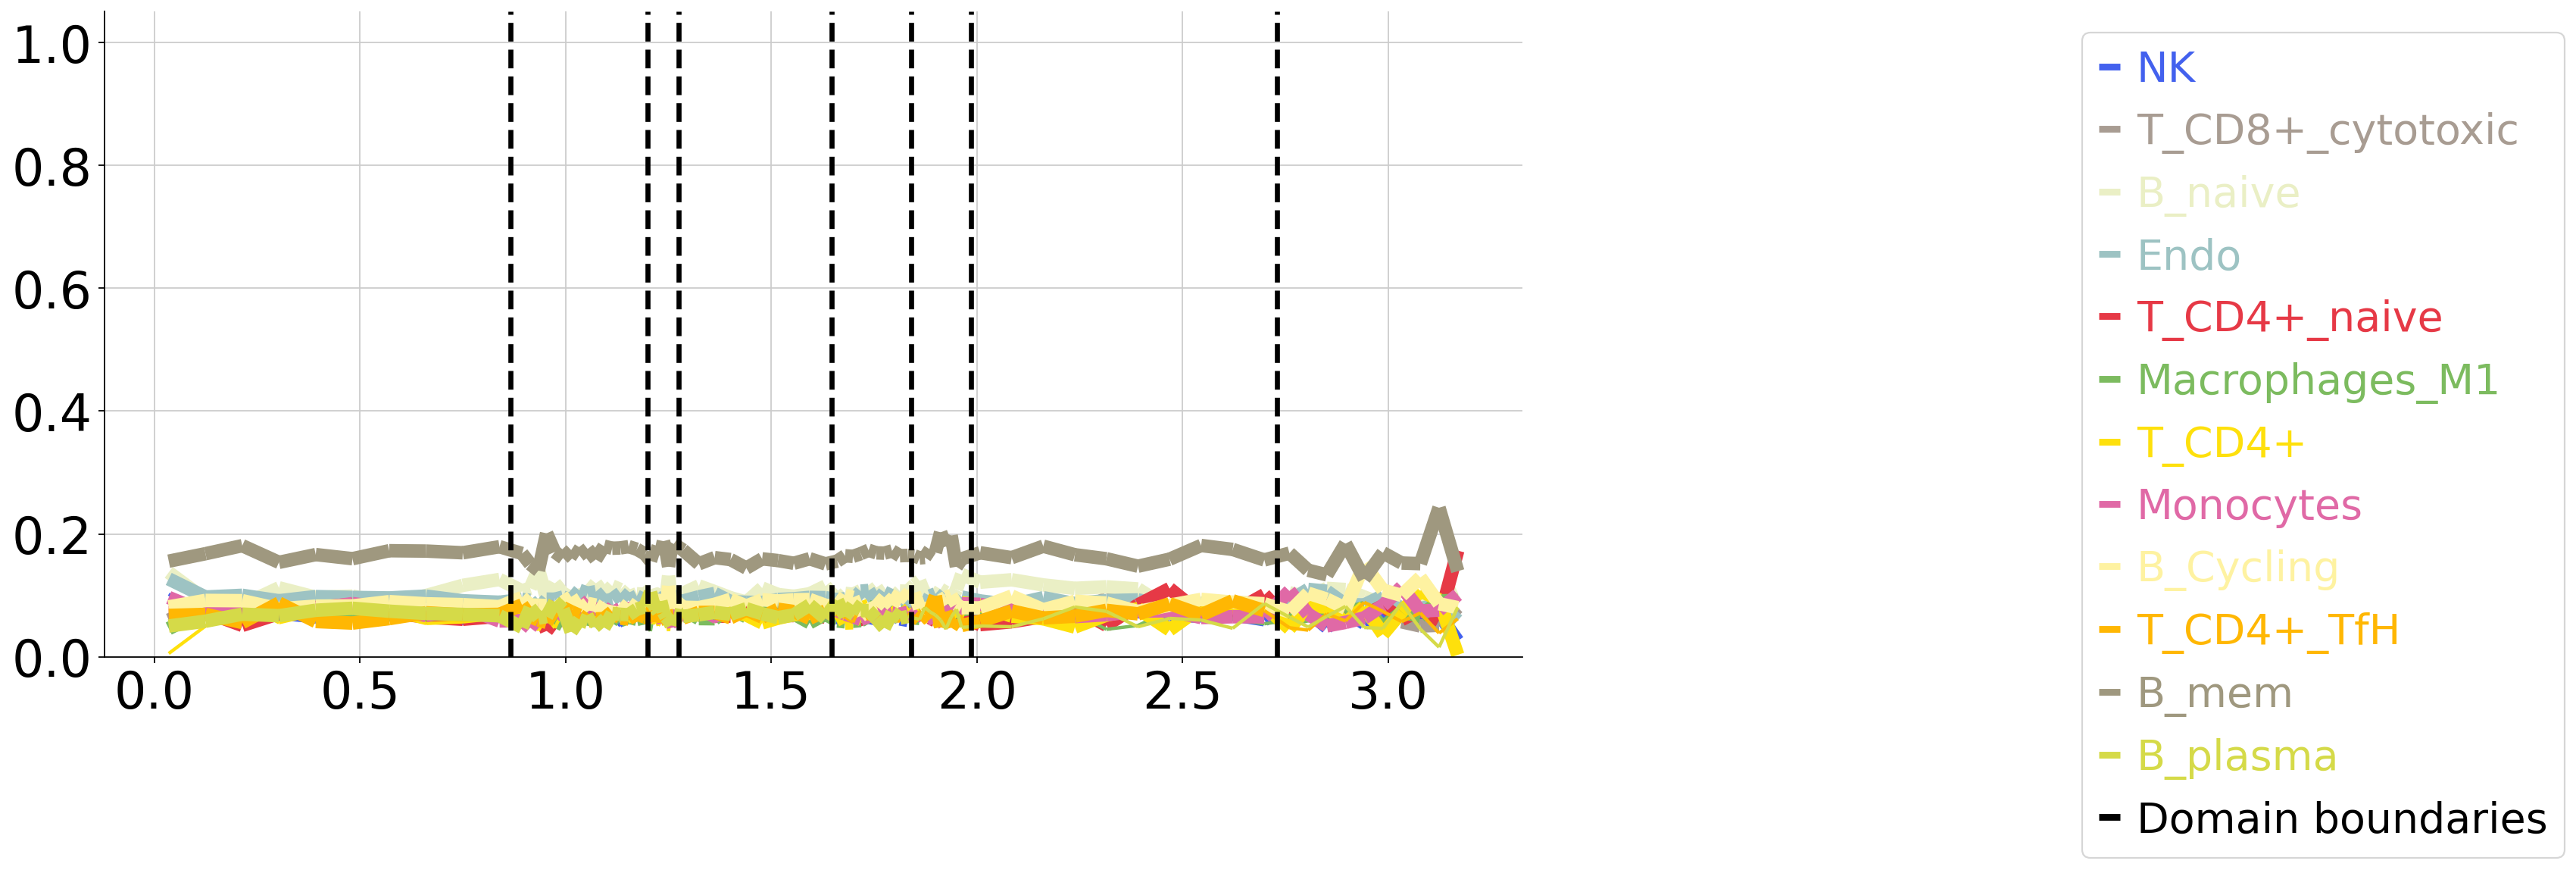

In [94]:
from omicverse.externel.gaston import plot_cell_types
ct_colors=dict(zip(
    cell_type_df.columns,
    ov.pl.sc_color+ov.utils._plot.palette_28
))
num_bins_per_domain=[10]*len(set(adata.obs['gaston_labels']))

plot_cell_types.plot_ct_props(
    cell_type_df, 
    gaston_labels, 
    gaston_isodepth, 
    num_bins_per_domain=num_bins_per_domain, 
    ct_colors=ct_colors, 
    ct_pseudocounts={3:1},
    include_lgd=True, 
    figsize=(15,7),
    ticksize=30, 
    width1=8, 
    width2=2, 
    domain_ct_threshold=0.5
)